In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
pwd

'/content'

In [3]:
# for Google Colab only: Mount my Google Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# for Google Colab only: Navigate to my snaug project folder
#cd 'My Drive/Colab Notebooks/cavy_breed_clf'

In [0]:
from pathlib import Path

In [0]:
proj_base = Path('/gdrive/My Drive/Colab Notebooks/cavy_breed_clf/')
proj_data = proj_base/'data'
proj_lib = proj_base/'lib'
proj_images = proj_base/'images'

In [0]:
!mkdir images

In [0]:
!cp -r "{proj_images}" .

In [8]:
!ls -al images

total 88
drwxr-xr-x 7 root root  4096 Dec 22 17:15 .
drwxr-xr-x 1 root root  4096 Dec 22 17:07 ..
drwx------ 2 root root 28672 Dec 22 17:13 Abyssinian
drwx------ 2 root root 20480 Dec 22 17:09 American
drwx------ 2 root root  4096 Dec 22 17:15 new_test
drwx------ 2 root root 12288 Dec 22 17:11 Silkie
drwx------ 2 root root 12288 Dec 22 17:15 Skinny


In [9]:
import sys
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [10]:
#sys.path.append("/gdrive/My Drive/Colab Notebooks/cavy_breed_clf/lib")
sys.path.append(str(proj_lib))
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/gdrive/My Drive/Colab Notebooks/cavy_breed_clf/lib']

In [2]:
from lib.data_common import (target_names, Read_and_Process_Image, 
                             Load_and_Split)
from lib.ml_common import (Vanilla_ML_Run, Vanilla_ML_Predict, 
                           Vanilla_ML_Run_CV, Show_Confusion_Matrix)
from lib.nn_common import (Image_CNN_Multilayer, Image_CNN_Multilayer_Train,
                           Image_CNN_From_InceptionV3,
                           Image_CNN_From_InceptionV3_Train, Image_NN_Predict,
                           Image_NN_Predict_One, Image_NN_Predict_Random_Test_Images,
                           Image_NN_Plt_Acc, Image_NN_Plt_Loss, 
                           Image_NN_Plt_Training, Image_NN_Plt_Validation,
                           Save_NN_Model_Data, Load_NN_Model_Data)
from lib.ml_common import (Plot_Precision_Recall_Curve, Plot_ROC_Curve,
                           Compare_Multiple_ROC_Curves)

Using TensorFlow backend.


In [3]:
import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

%matplotlib inline

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [5]:
# fix random seed for reproducibility
seed = 128
np.random.seed(seed)

# Image size for standardisation
image_shape = (150, 150)
input_shape = (-1, 150, 150, 3)

batch_size = 64

In [6]:
# Load pre-split data from training, validation and test data sets
print(">>> Loading data")
X_train, y_train = Load_and_Split('data/cavy_data_train.csv', image_shape)
X_val, y_val = Load_and_Split('data/cavy_data_val.csv', image_shape)
X_test, y_test = Load_and_Split('data/cavy_data_test.csv', image_shape)
#X_train, y_train = Load_and_Split(str(proj_data/'cavy_data_train.csv'), image_shape)
#X_val, y_val = Load_and_Split(str(proj_data/'cavy_data_val.csv'), image_shape)
#X_test, y_test = Load_and_Split(str(proj_data/'cavy_data_test.csv'), image_shape)

>>> Loading data


In [7]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1043, 67500) (1043, 4)
(261, 67500) (261, 4)
(327, 67500) (327, 4)


In [8]:
X_train[:3]

array([[163, 179, 196, ..., 232, 237, 252],
       [  1,  65,  66, ..., 204, 180, 157],
       [ 64,  62,  74, ...,  44, 105, 153]], dtype=uint8)

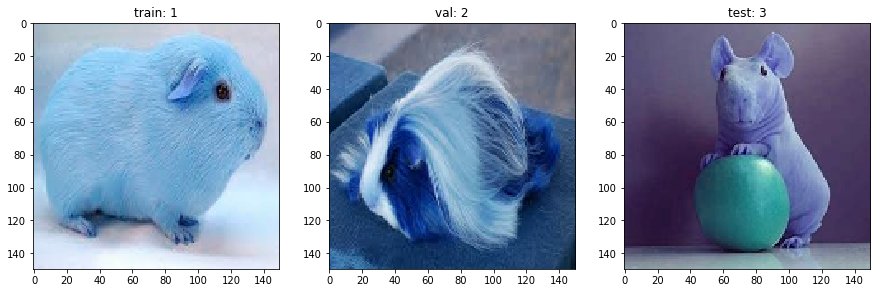

In [9]:
plt.figure(figsize=(15,25))
plt.subplot(1, 3, 1)
_ = plt.title('train: ' + str(np.argmax(y_train[0])))
_ = plt.imshow(X_train[0].reshape(150,150,3))
plt.subplot(1, 3, 2)
_ = plt.title('val: ' + str(np.argmax(y_val[0])))
_ = plt.imshow(X_val[0].reshape(150,150,3))
plt.subplot(1, 3, 3)
_ = plt.title('test: ' + str(np.argmax(y_test[0])))
_ = plt.imshow(X_test[0].reshape(150,150,3))

In [37]:
# Multilayer Image CNN

model_ml_cnn = Image_CNN_Multilayer(num_target=4, input_shape=(150,150,3))
print(model_ml_cnn.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 128)      

In [38]:
model_ml_cnn , history_ml_cnn = Image_CNN_Multilayer_Train(model_ml_cnn, 
                                     X_train.reshape(input_shape), 
                                     y_train,
                                     X_val.reshape(input_shape), 
                                     y_val, 
                                     epochs=100,
                                     batch_size=batch_size, 
                                     verbose=1)

>> Training multilayer image CNN
Epoch 1/100
17/17 [==============================] - 6s 351ms/step - loss: 1.3542 - categorical_accuracy: 0.3306 - val_loss: 1.3255 - val_categorical_accuracy: 0.3333
Epoch 2/100
17/17 [==============================] - 5s 310ms/step - loss: 1.3254 - categorical_accuracy: 0.3242 - val_loss: 1.3171 - val_categorical_accuracy: 0.3372
Epoch 3/100
17/17 [==============================] - 5s 314ms/step - loss: 1.3053 - categorical_accuracy: 0.3406 - val_loss: 1.2856 - val_categorical_accuracy: 0.3372
Epoch 4/100
17/17 [==============================] - 5s 309ms/step - loss: 1.2833 - categorical_accuracy: 0.3912 - val_loss: 1.2693 - val_categorical_accuracy: 0.4368
Epoch 5/100
17/17 [==============================] - 5s 312ms/step - loss: 1.2593 - categorical_accuracy: 0.3931 - val_loss: 1.2622 - val_categorical_accuracy: 0.3525
Epoch 6/100
17/17 [==============================] - 5s 306ms/step - loss: 1.2383 - categorical_accuracy: 0.4152 - val_loss: 1.2677 

In [39]:
%cd "{proj_base}"

/gdrive/My Drive/Colab Notebooks/cavy_breed_clf


In [0]:
model_ml_cnn_name = 'cnn_multilayer_v2_epoch-100'

In [0]:
# Save_NN_Model_Data(model_ml_cnn, history_ml_cnn, model_ml_cnn_name)

In [0]:
model_ml_cnn, history_ml_cnn = Load_NN_Model_Data(model_ml_cnn_name)

In [43]:
%cd '/content'

/content


In [44]:
results_ml_cnn = {k: history_ml_cnn.history[k][-1] for k in history_ml_cnn.history.keys()}
results_ml_cnn

{'categorical_accuracy': 0.7967401725219514,
 'loss': 0.5101637875130856,
 'val_categorical_accuracy': 0.6475095790008019,
 'val_loss': 0.9622068687188671}

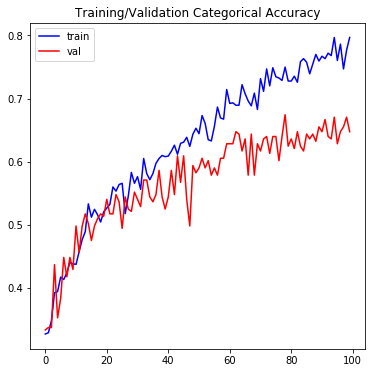

In [46]:
Image_NN_Plt_Acc(history_ml_cnn)

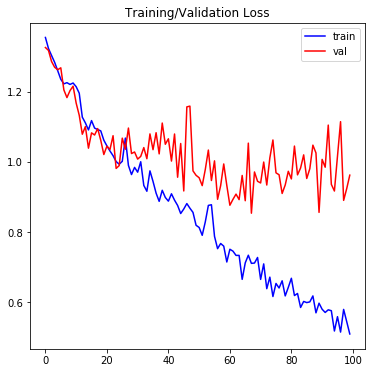

In [117]:
Image_NN_Plt_Loss(history_ml_cnn)

In [45]:
clf_report_ml_cnn, cf_matrix_ml_cnn, y_pred_ml_cnn, y_pred_bool_ml_cnn = Image_NN_Predict(model_ml_cnn, 
                                                        X_val.reshape((input_shape)), 
                                                        y_val, 
                                                        target_names=target_names,
                                                        batch_size=batch_size, 
                                                        verbose=2)

>> Predicting on neural network
              precision    recall  f1-score   support

  Abyssinian       0.67      0.70      0.69        88
    American       0.55      0.71      0.62        83
      Silkie       0.75      0.35      0.48        43
      Skinny       0.79      0.70      0.74        47

    accuracy                           0.65       261
   macro avg       0.69      0.62      0.63       261
weighted avg       0.67      0.65      0.64       261

[[62 24  1  1]
 [14 59  4  6]
 [13 13 15  2]
 [ 3 11  0 33]]



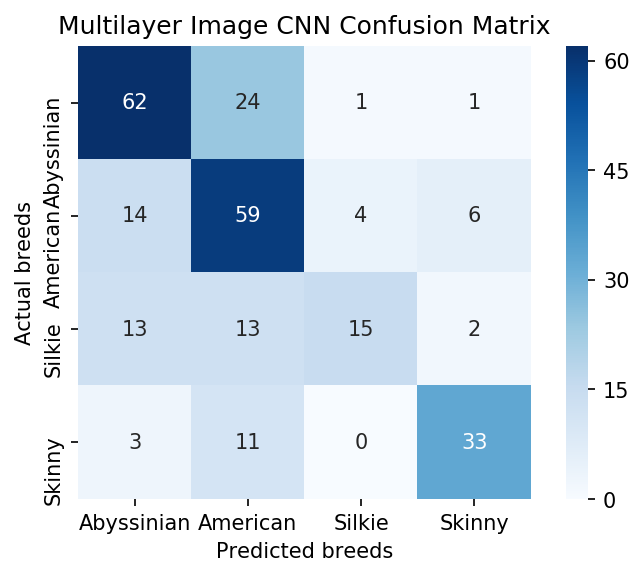

In [100]:
Show_Confusion_Matrix(cf_matrix_ml_cnn, target_names, clf_name="Multilayer Image CNN")

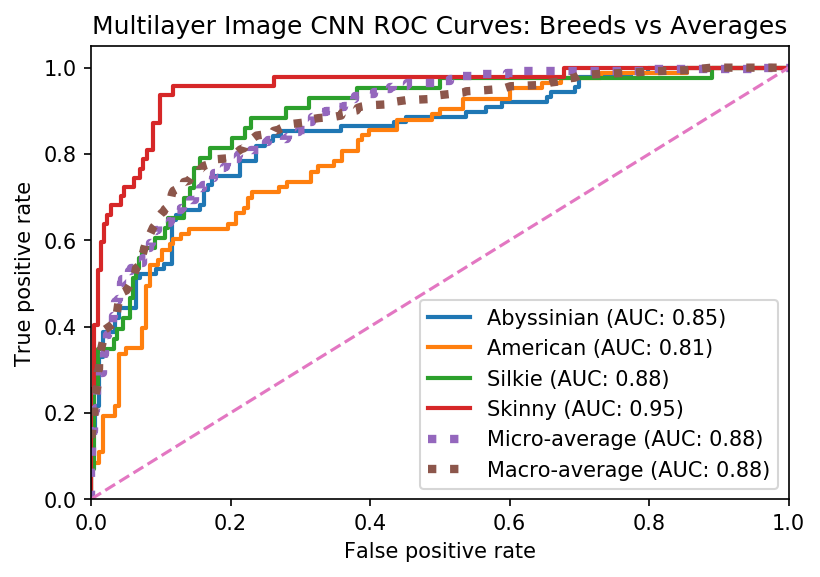

In [104]:
_ = Plot_ROC_Curve(y_val, y_pred_ml_cnn, target_names, clf_name="Multilayer Image CNN")

In [49]:
# Transfer learning from InceptionV3, freezing 220 layers
model_inc_v3_220 = Image_CNN_From_InceptionV3(num_target=4, input_shape=(150,150,3))
#print(model_1.summary())



87916544/87910968 [==============================] - 3s 0us/step


In [52]:
model_inc_v3_220, history_inc_v3_220_1, history_inc_v3_220_2 = Image_CNN_From_InceptionV3_Train(model_inc_v3_220, 
                                     X_train.reshape((input_shape)), 
                                     y_train,
                                     X_val.reshape((input_shape)),
                                     y_val, 
                                     epochs=100,
                                     batch_size=batch_size, 
                                     freeze_layer=220,
                                     verbose=1)

>>> Training with pre-trained Inception v3
 >> Training model with new data
Epoch 1/100
 - 10s - loss: 5.7426 - categorical_accuracy: 0.3638 - val_loss: 2.1848 - val_categorical_accuracy: 0.5211
Epoch 2/100
 - 4s - loss: 1.4527 - categorical_accuracy: 0.5118 - val_loss: 4.9280 - val_categorical_accuracy: 0.3946
Epoch 3/100
 - 5s - loss: 0.9985 - categorical_accuracy: 0.6166 - val_loss: 1.2586 - val_categorical_accuracy: 0.7280
Epoch 4/100
 - 5s - loss: 1.0512 - categorical_accuracy: 0.6384 - val_loss: 5.6383 - val_categorical_accuracy: 0.3985
Epoch 5/100
 - 5s - loss: 0.9668 - categorical_accuracy: 0.6380 - val_loss: 0.8440 - val_categorical_accuracy: 0.7893
Epoch 6/100
 - 5s - loss: 0.8321 - categorical_accuracy: 0.6768 - val_loss: 4.6280 - val_categorical_accuracy: 0.5709
Epoch 7/100
 - 5s - loss: 0.6707 - categorical_accuracy: 0.7596 - val_loss: 2.9369 - val_categorical_accuracy: 0.6552
Epoch 8/100
 - 5s - loss: 0.7324 - categorical_accuracy: 0.7356 - val_loss: 1.9076 - val_categori

In [53]:
%cd "{proj_base}"

/gdrive/My Drive/Colab Notebooks/cavy_breed_clf


In [0]:
model_inc_v3_220_name = 'inceptionV3_tuned_freeze-220_sgd_v2_epoch-100'

In [0]:
# Save_NN_Model_Data(model_inc_v3_220, history_inc_v3_220_2, model_inc_v3_220_name)

In [0]:
model_inc_v3_220, history_inc_v3_220 = Load_NN_Model_Data(model_inc_v3_220_name)

In [62]:
%cd "/content"

/content


In [63]:
results_inc_v3_220 = {k: history_inc_v3_220.history[k][-1] for k in history_inc_v3_220.history.keys()}
results_inc_v3_220

{'categorical_accuracy': 0.9894534995206136,
 'loss': 0.01925387684780879,
 'val_categorical_accuracy': 0.89272030651341,
 'val_loss': 0.9563728061761927}

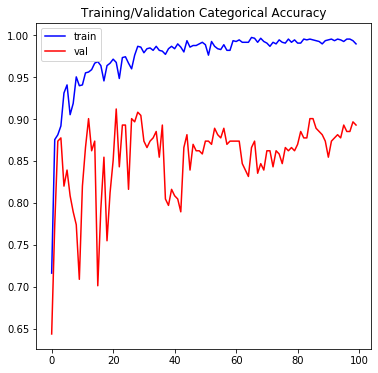

In [65]:
Image_NN_Plt_Acc(history_inc_v3_220)

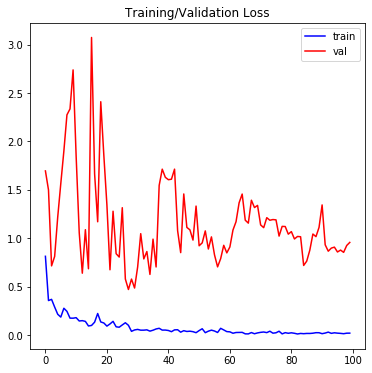

In [66]:
Image_NN_Plt_Loss(history_inc_v3_220)

In [71]:
clf_report_inc_v3_220, cf_matrix_inc_v3_220, y_pred_inc_v3_220, y_bool_inc_v3_220 = Image_NN_Predict(model_inc_v3_220,
                                                    X_val.reshape(input_shape), 
                                                    y_val, 
                                                    target_names=target_names,
                                                    batch_size=batch_size, 
                                                    verbose=2)

>> Predicting on neural network
              precision    recall  f1-score   support

  Abyssinian       1.00      0.78      0.88        88
    American       0.76      0.98      0.86        83
      Silkie       0.95      0.91      0.93        43
      Skinny       0.98      0.94      0.96        47

    accuracy                           0.89       261
   macro avg       0.92      0.90      0.91       261
weighted avg       0.91      0.89      0.89       261

[[69 18  1  0]
 [ 0 81  1  1]
 [ 0  4 39  0]
 [ 0  3  0 44]]



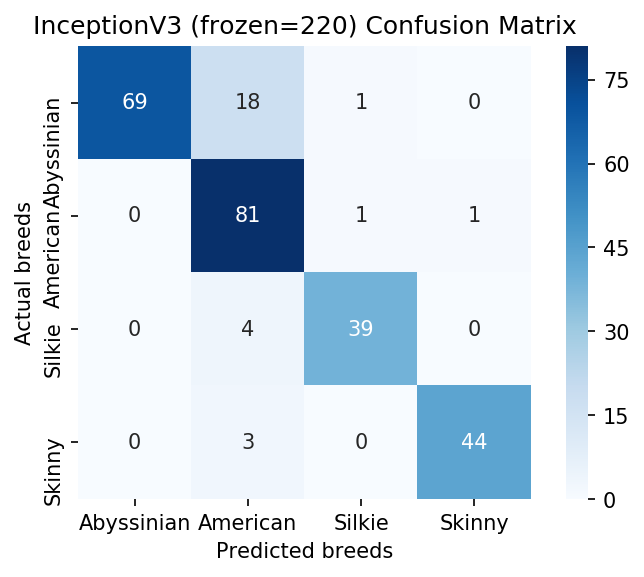

In [101]:
Show_Confusion_Matrix(cf_matrix_inc_v3_220, target_names, clf_name="InceptionV3 (frozen=220)")

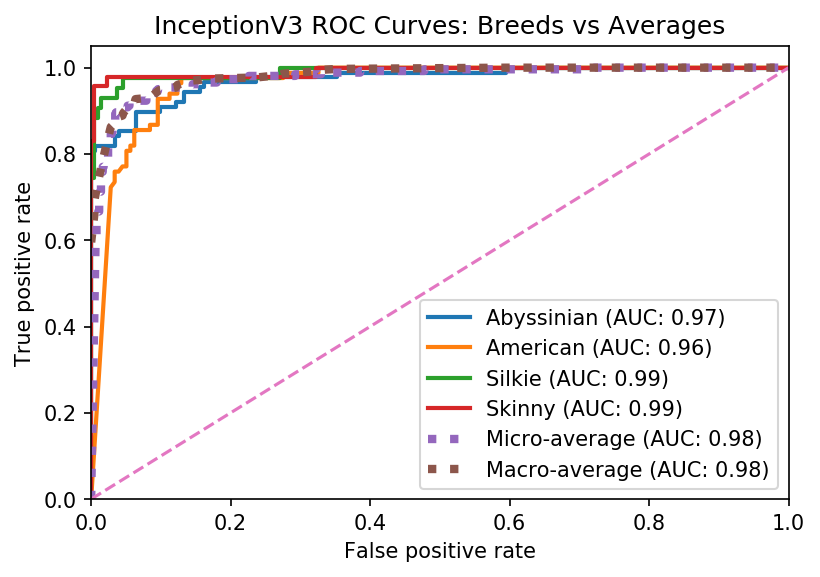

In [73]:
fpr, tpr, roc_auc = Plot_ROC_Curve(y_val, y_pred_inc_v3_220, 
                                       target_names, clf_name="InceptionV3")

In [0]:
# Transfer learning from InceptionV3, freezing 230 layers
model_inc_v3_230 = Image_CNN_From_InceptionV3(num_target=4, input_shape=(150,150,3))

In [106]:
model_inc_v3_230, history_inc_v3_230_1, history_inc_v3_230_2 = Image_CNN_From_InceptionV3_Train(model_inc_v3_230, 
                                     X_train.reshape((input_shape)), 
                                     y_train,
                                     X_val.reshape((input_shape)),
                                     y_val, 
                                     epochs=100,
                                     batch_size=batch_size, 
                                     freeze_layer=230,
                                     verbose=1)

>>> Training with pre-trained Inception v3
 >> Training model with new data
Epoch 1/100
 - 14s - loss: 4.2456 - categorical_accuracy: 0.4018 - val_loss: 1.0967 - val_categorical_accuracy: 0.6169
Epoch 2/100
 - 4s - loss: 1.0327 - categorical_accuracy: 0.5814 - val_loss: 6.4313 - val_categorical_accuracy: 0.3372
Epoch 3/100
 - 5s - loss: 1.0329 - categorical_accuracy: 0.6157 - val_loss: 4.9125 - val_categorical_accuracy: 0.2605
Epoch 4/100
 - 5s - loss: 0.9060 - categorical_accuracy: 0.6377 - val_loss: 3.9691 - val_categorical_accuracy: 0.5172
Epoch 5/100
 - 5s - loss: 0.8871 - categorical_accuracy: 0.6788 - val_loss: 2.0908 - val_categorical_accuracy: 0.6207
Epoch 6/100
 - 5s - loss: 0.8285 - categorical_accuracy: 0.6719 - val_loss: 3.5417 - val_categorical_accuracy: 0.5172
Epoch 7/100
 - 5s - loss: 0.7416 - categorical_accuracy: 0.7133 - val_loss: 3.1230 - val_categorical_accuracy: 0.5670
Epoch 8/100
 - 5s - loss: 0.7819 - categorical_accuracy: 0.6957 - val_loss: 1.0123 - val_categori

In [108]:
%cd "{proj_base}"

/gdrive/My Drive/Colab Notebooks/cavy_breed_clf


In [10]:
model_inc_v3_230_name = 'inceptionV3_tuned_freeze-230_sgd_v2_epoch-100'

In [11]:
#Save_NN_Model_Data(model_inc_v3_230, history_inc_v3_230_2, model_inc_v3_230_name)

In [12]:
model_inc_v3_230, history_inc_v3_230 = Load_NN_Model_Data(model_inc_v3_230_name)














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [112]:
%cd "/content"

/content


In [13]:
results_inc_v3_230 = {k: history_inc_v3_230.history[k][-1] for k in history_inc_v3_230.history.keys()}
results_inc_v3_230

{'val_loss': 0.7113691623189566,
 'val_categorical_accuracy': 0.8888888888888888,
 'loss': 0.03206774005568153,
 'categorical_accuracy': 0.9913710450623202}

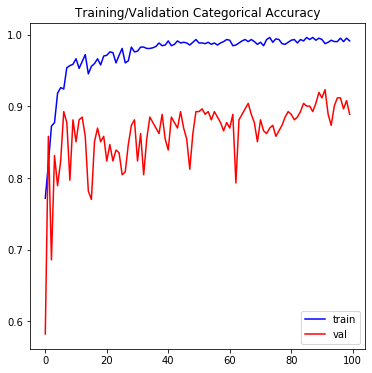

In [116]:
Image_NN_Plt_Acc(history_inc_v3_230)

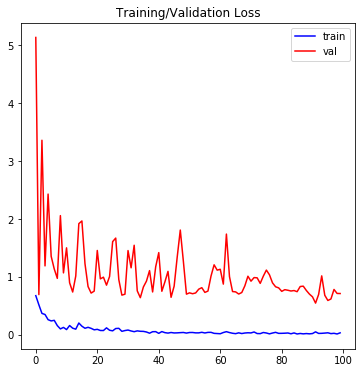

In [114]:
Image_NN_Plt_Loss(history_inc_v3_230)

In [14]:
clf_report_inc_v3_230, cf_matrix_inc_v3_230, y_pred_inc_v3_230, y_bool_inc_v3_230 = Image_NN_Predict(model_inc_v3_230,
                                                    X_val.reshape(input_shape), 
                                                    y_val, 
                                                    target_names=target_names,
                                                    batch_size=batch_size, 
                                                    verbose=2)

>> Predicting on neural network


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node batch_normalization_96/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[dense_14/Softmax/_6915]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node batch_normalization_96/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

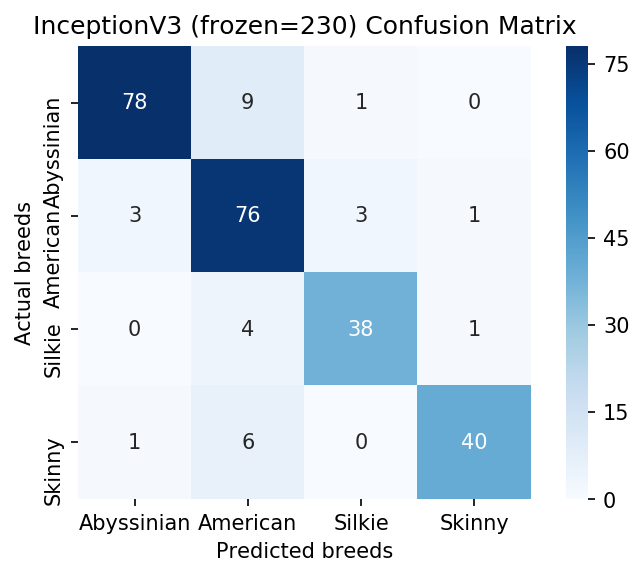

In [119]:
Show_Confusion_Matrix(cf_matrix_inc_v3_230, target_names, clf_name="InceptionV3 (frozen=230)")

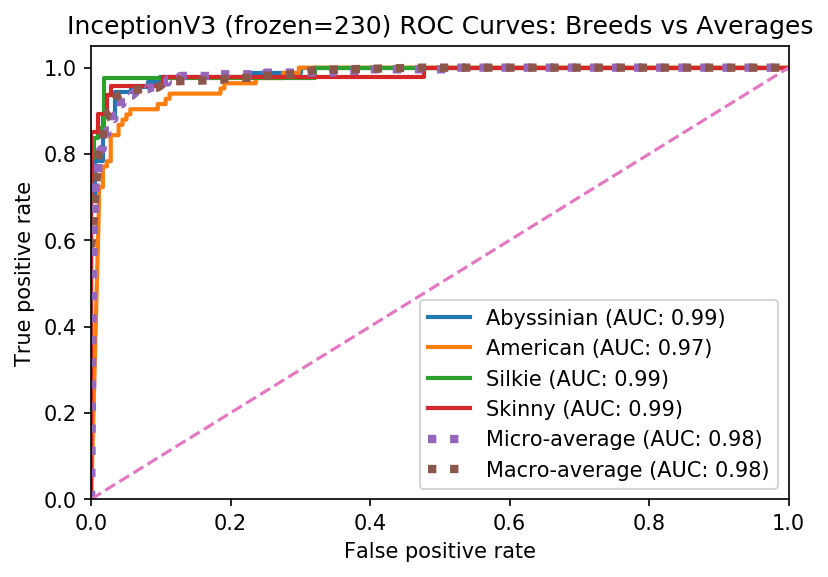

In [120]:
_ = Plot_ROC_Curve(y_val, y_pred_inc_v3_230, target_names, clf_name="InceptionV3 (frozen=230)")

In [0]:
# Transfer learning from InceptionV3, freezing 240 layers
model_inc_v3_240 = Image_CNN_From_InceptionV3(num_target=4, input_shape=(150,150,3))

In [122]:
model_inc_v3_240, history_inc_v3_240_1, history_inc_v3_240_2 = Image_CNN_From_InceptionV3_Train(model_inc_v3_240, 
                                     X_train.reshape((input_shape)), 
                                     y_train,
                                     X_val.reshape((input_shape)),
                                     y_val, 
                                     epochs=100,
                                     batch_size=batch_size, 
                                     freeze_layer=240,
                                     verbose=1)

>>> Training with pre-trained Inception v3
 >> Training model with new data
Epoch 1/100
 - 18s - loss: 3.5818 - categorical_accuracy: 0.4024 - val_loss: 1.0927 - val_categorical_accuracy: 0.7050
Epoch 2/100
 - 3s - loss: 0.9624 - categorical_accuracy: 0.6342 - val_loss: 3.0202 - val_categorical_accuracy: 0.5249
Epoch 3/100
 - 5s - loss: 1.0455 - categorical_accuracy: 0.6270 - val_loss: 4.5909 - val_categorical_accuracy: 0.5517
Epoch 4/100
 - 5s - loss: 1.0474 - categorical_accuracy: 0.6325 - val_loss: 4.3032 - val_categorical_accuracy: 0.4674
Epoch 5/100
 - 5s - loss: 0.7936 - categorical_accuracy: 0.7011 - val_loss: 4.2917 - val_categorical_accuracy: 0.5709
Epoch 6/100
 - 5s - loss: 0.7368 - categorical_accuracy: 0.6958 - val_loss: 0.7338 - val_categorical_accuracy: 0.8238
Epoch 7/100
 - 5s - loss: 0.7863 - categorical_accuracy: 0.7091 - val_loss: 1.2651 - val_categorical_accuracy: 0.7663
Epoch 8/100
 - 5s - loss: 0.7403 - categorical_accuracy: 0.7345 - val_loss: 2.6573 - val_categori

In [125]:
%cd "{proj_base}"

/gdrive/My Drive/Colab Notebooks/cavy_breed_clf


In [0]:
model_inc_v3_240_name = 'inceptionV3_tuned_freeze-240_sgd_v2_epoch-100'

In [0]:
#Save_NN_Model_Data(model_inc_v3_240, history_inc_v3_240_2, model_inc_v3_240_name)

In [0]:
model_inc_v3_240, history_inc_v3_240 = Load_NN_Model_Data(model_inc_v3_240_name)

In [129]:
%cd "/content"

/content


In [130]:
results_inc_v3_240 = {k: history_inc_v3_240.history[k][-1] for k in history_inc_v3_240.history.keys()}
results_inc_v3_240

{'categorical_accuracy': 0.9913710450623202,
 'loss': 0.02146140153766257,
 'val_categorical_accuracy': 0.8773946360153256,
 'val_loss': 0.7576728785175019}

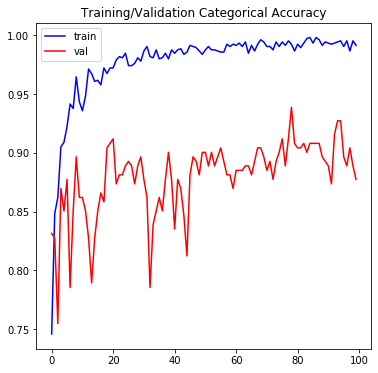

In [131]:
Image_NN_Plt_Acc(history_inc_v3_240)

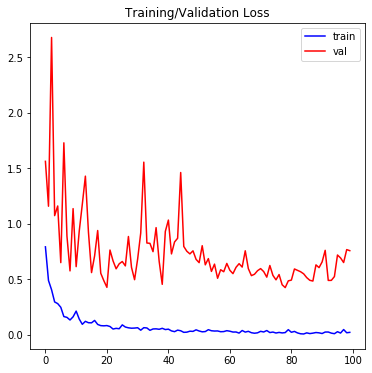

In [132]:
Image_NN_Plt_Loss(history_inc_v3_240)

In [133]:
clf_report_inc_v3_240, cf_matrix_inc_v3_240, y_pred_inc_v3_240, y_bool_inc_v3_240 = Image_NN_Predict(model_inc_v3_240,
                                                    X_val.reshape(input_shape), 
                                                    y_val, 
                                                    target_names=target_names,
                                                    batch_size=batch_size, 
                                                    verbose=2)

>> Predicting on neural network
              precision    recall  f1-score   support

  Abyssinian       0.88      0.90      0.89        88
    American       0.80      0.89      0.84        83
      Silkie       0.97      0.81      0.89        43
      Skinny       0.98      0.87      0.92        47

    accuracy                           0.88       261
   macro avg       0.91      0.87      0.88       261
weighted avg       0.88      0.88      0.88       261

[[79  9  0  0]
 [ 7 74  1  1]
 [ 2  6 35  0]
 [ 2  4  0 41]]



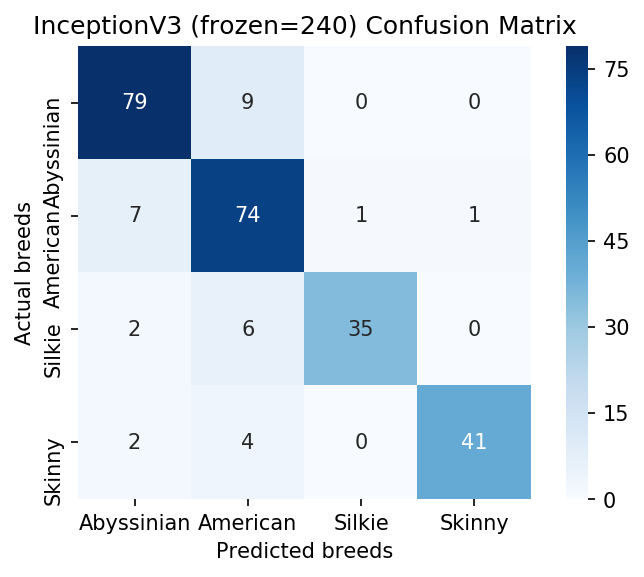

In [134]:
Show_Confusion_Matrix(cf_matrix_inc_v3_240, target_names, clf_name="InceptionV3 (frozen=240)")

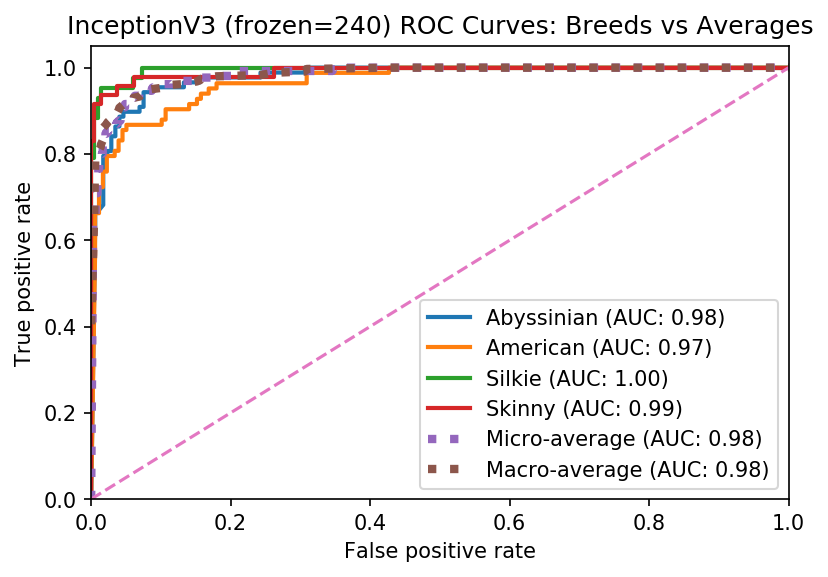

In [135]:
_ = Plot_ROC_Curve(y_val, y_pred_inc_v3_240, target_names, clf_name="InceptionV3 (frozen=240)")

In [0]:
# Transfer learning from InceptionV3, freezing 249 layers
model_inc_v3_249 = Image_CNN_From_InceptionV3(num_target=4, input_shape=(150,150,3))

In [140]:
model_inc_v3_249, history_inc_v3_249_1, history_inc_v3_249_2 = Image_CNN_From_InceptionV3_Train(model_inc_v3_249, 
                                     X_train.reshape((input_shape)), 
                                     y_train,
                                     X_val.reshape((input_shape)),
                                     y_val, 
                                     epochs=100,
                                     batch_size=batch_size, 
                                     freeze_layer=249,
                                     verbose=1)

>>> Training with pre-trained Inception v3
 >> Training model with new data
Epoch 1/100
 - 24s - loss: 5.0875 - categorical_accuracy: 0.3696 - val_loss: 5.7306 - val_categorical_accuracy: 0.1801
Epoch 2/100
 - 2s - loss: 1.2210 - categorical_accuracy: 0.5729 - val_loss: 0.4908 - val_categorical_accuracy: 0.8008
Epoch 3/100
 - 5s - loss: 1.1271 - categorical_accuracy: 0.6053 - val_loss: 3.3079 - val_categorical_accuracy: 0.5249
Epoch 4/100
 - 5s - loss: 0.9615 - categorical_accuracy: 0.6578 - val_loss: 5.7745 - val_categorical_accuracy: 0.2989
Epoch 5/100
 - 5s - loss: 0.9234 - categorical_accuracy: 0.6537 - val_loss: 3.5399 - val_categorical_accuracy: 0.6054
Epoch 6/100
 - 5s - loss: 0.7435 - categorical_accuracy: 0.7218 - val_loss: 4.8745 - val_categorical_accuracy: 0.4943
Epoch 7/100
 - 5s - loss: 0.8053 - categorical_accuracy: 0.7131 - val_loss: 1.7699 - val_categorical_accuracy: 0.6513
Epoch 8/100
 - 5s - loss: 0.9563 - categorical_accuracy: 0.6668 - val_loss: 3.3307 - val_categori

In [141]:
%cd "{proj_base}"

/gdrive/My Drive/Colab Notebooks/cavy_breed_clf


In [0]:
model_inc_v3_249_name = 'inceptionV3_tuned_freeze-249_sgd_v2_epoch-100'

In [0]:
#Save_NN_Model_Data(model_inc_v3_249, history_inc_v3_249_2, model_inc_v3_249_name)

In [0]:
model_inc_v3_249, history_inc_v3_249 = Load_NN_Model_Data(model_inc_v3_249_name)

In [145]:
%cd "/content"

/content


In [146]:
results_inc_v3_249 = {k: history_inc_v3_249.history[k][-1] for k in history_inc_v3_249.history.keys()}
results_inc_v3_249

{'categorical_accuracy': 0.9904122722914669,
 'loss': 0.021642927760803003,
 'val_categorical_accuracy': 0.8735632183908046,
 'val_loss': 0.8671165460768914}

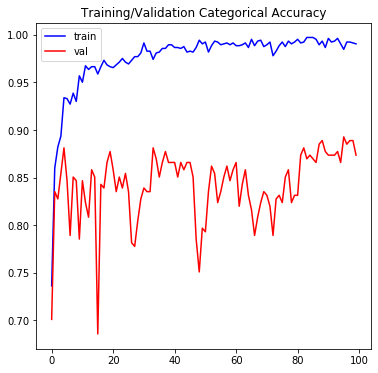

In [147]:
Image_NN_Plt_Acc(history_inc_v3_249)

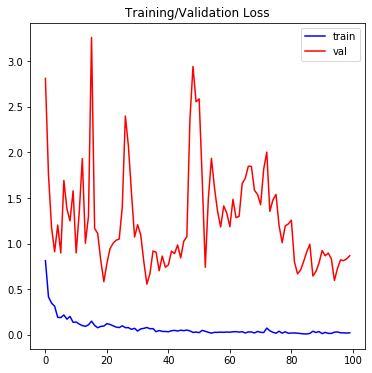

In [148]:
Image_NN_Plt_Loss(history_inc_v3_249)

In [149]:
clf_report_inc_v3_249, cf_matrix_inc_v3_249, y_pred_inc_v3_249, y_bool_inc_v3_249 = Image_NN_Predict(model_inc_v3_249,
                                                    X_val.reshape(input_shape), 
                                                    y_val, 
                                                    target_names=target_names,
                                                    batch_size=batch_size, 
                                                    verbose=2)

>> Predicting on neural network
              precision    recall  f1-score   support

  Abyssinian       0.99      0.76      0.86        88
    American       0.77      0.95      0.85        83
      Silkie       0.85      0.93      0.89        43
      Skinny       0.98      0.89      0.93        47

    accuracy                           0.87       261
   macro avg       0.90      0.88      0.88       261
weighted avg       0.89      0.87      0.87       261

[[67 18  3  0]
 [ 0 79  3  1]
 [ 0  3 40  0]
 [ 1  3  1 42]]



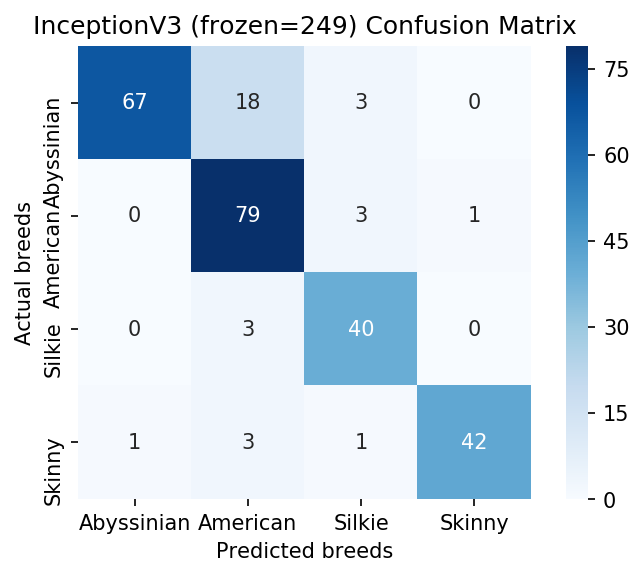

In [150]:
Show_Confusion_Matrix(cf_matrix_inc_v3_249, target_names, clf_name="InceptionV3 (frozen=249)")

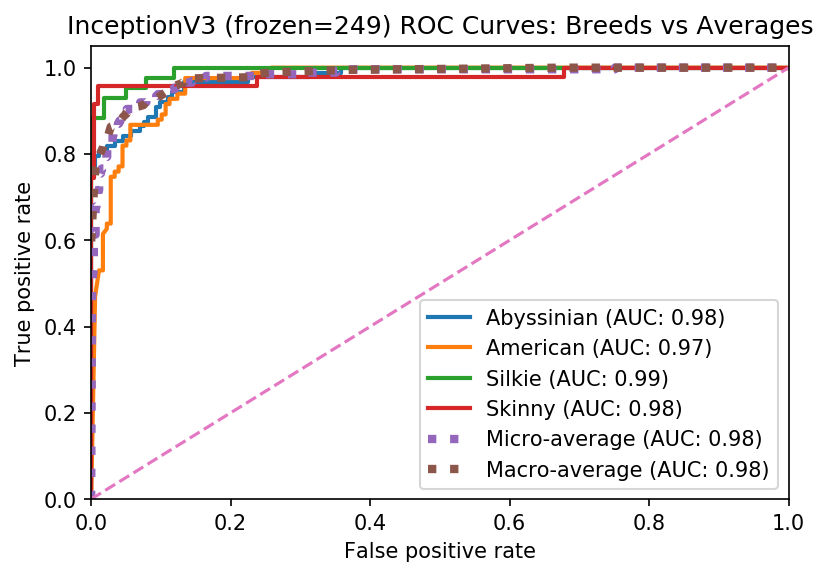

In [151]:
_ = Plot_ROC_Curve(y_val, y_pred_inc_v3_249, target_names, clf_name="InceptionV3 (frozen=249)")

In [0]:
# Compare ROC curves and AUC scores between different models

In [0]:
y_test_dict = dict()
y_score_dict = dict()

In [0]:
y_test_dict['ML-CNN'] = y_val
y_score_dict['ML-CNN'] = y_pred_ml_cnn
y_test_dict['InceptionV3_220'] = y_val
y_score_dict['InceptionV3_220'] = y_pred_inc_v3_220
y_test_dict['InceptionV3_230'] = y_val
y_score_dict['InceptionV3_230'] = y_pred_inc_v3_230
y_test_dict['InceptionV3_235'] = y_val
y_score_dict['InceptionV3_235'] = y_pred_inc_v3_235
y_test_dict['InceptionV3_240'] = y_val
y_score_dict['InceptionV3_240'] = y_pred_inc_v3_240
y_test_dict['InceptionV3_249'] = y_val
y_score_dict['InceptionV3_249'] = y_pred_inc_v3_249

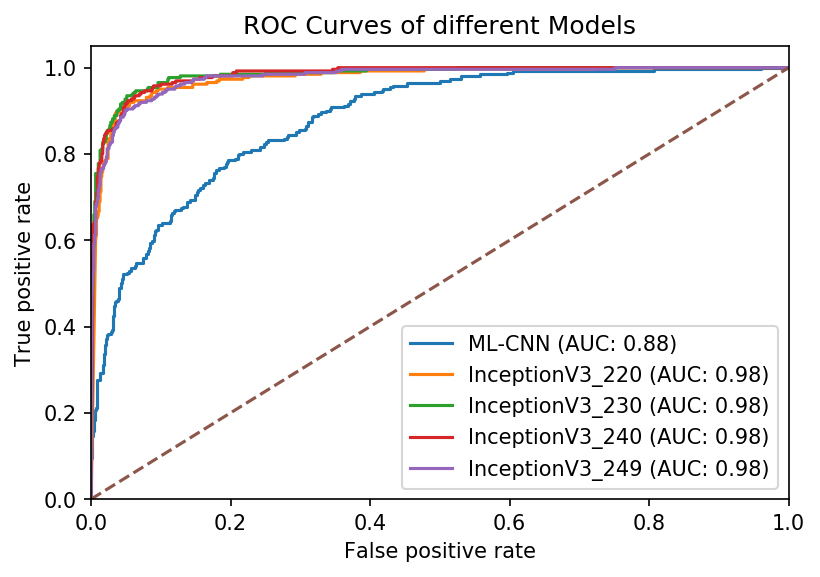

In [158]:
Compare_Multiple_ROC_Curves(y_test_dict, y_score_dict)

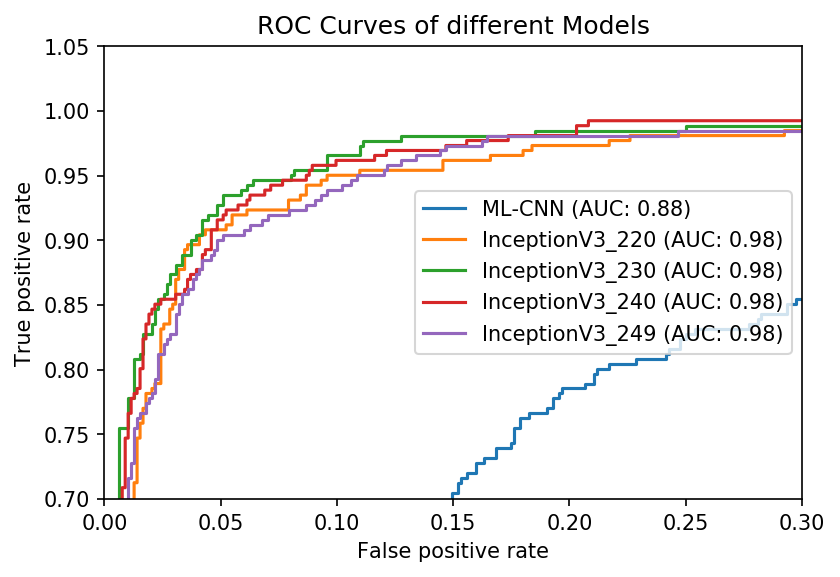

In [181]:
Compare_Multiple_ROC_Curves(y_test_dict, y_score_dict, zoom_level=0.3)

In [0]:
# Deep dive best InceptionV3 model

In [201]:
# using validation dataset
_ = Image_NN_Predict(model_inc_v3_230,
                    X_val.reshape(input_shape), 
                    y_val, 
                    target_names=target_names,
                    batch_size=batch_size, 
                    verbose=2)

>> Predicting on neural network
              precision    recall  f1-score   support

  Abyssinian       0.95      0.89      0.92        88
    American       0.80      0.92      0.85        83
      Silkie       0.90      0.88      0.89        43
      Skinny       0.95      0.85      0.90        47

    accuracy                           0.89       261
   macro avg       0.90      0.88      0.89       261
weighted avg       0.90      0.89      0.89       261

[[78  9  1  0]
 [ 3 76  3  1]
 [ 0  4 38  1]
 [ 1  6  0 40]]



In [202]:
# using validation dataset
_ = Image_NN_Predict(model_inc_v3_230,
                    X_test.reshape(input_shape), 
                    y_test, 
                    target_names=target_names,
                    batch_size=batch_size, 
                    verbose=2)

>> Predicting on neural network
              precision    recall  f1-score   support

  Abyssinian       0.94      0.92      0.93       111
    American       0.84      0.95      0.89       104
      Silkie       1.00      0.91      0.95        53
      Skinny       1.00      0.88      0.94        59

    accuracy                           0.92       327
   macro avg       0.94      0.91      0.93       327
weighted avg       0.93      0.92      0.92       327

[[102   9   0   0]
 [  5  99   0   0]
 [  2   3  48   0]
 [  0   7   0  52]]



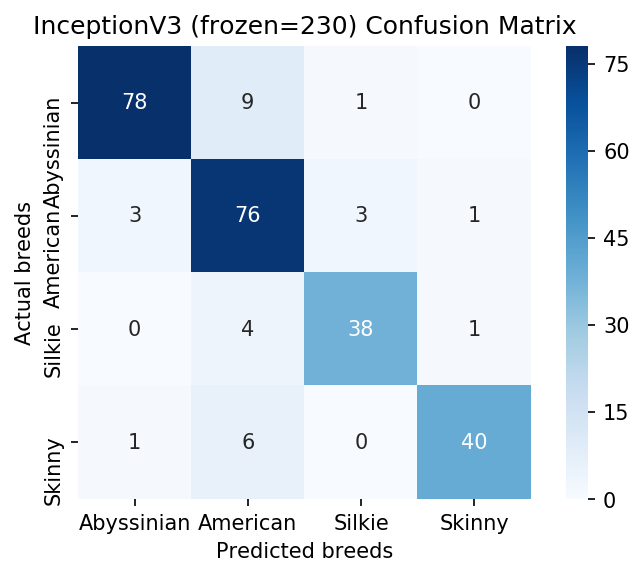

In [203]:
Show_Confusion_Matrix(cf_matrix_inc_v3_230, target_names, clf_name="InceptionV3 (frozen=230)")

>> Predicting on randomly selected test images


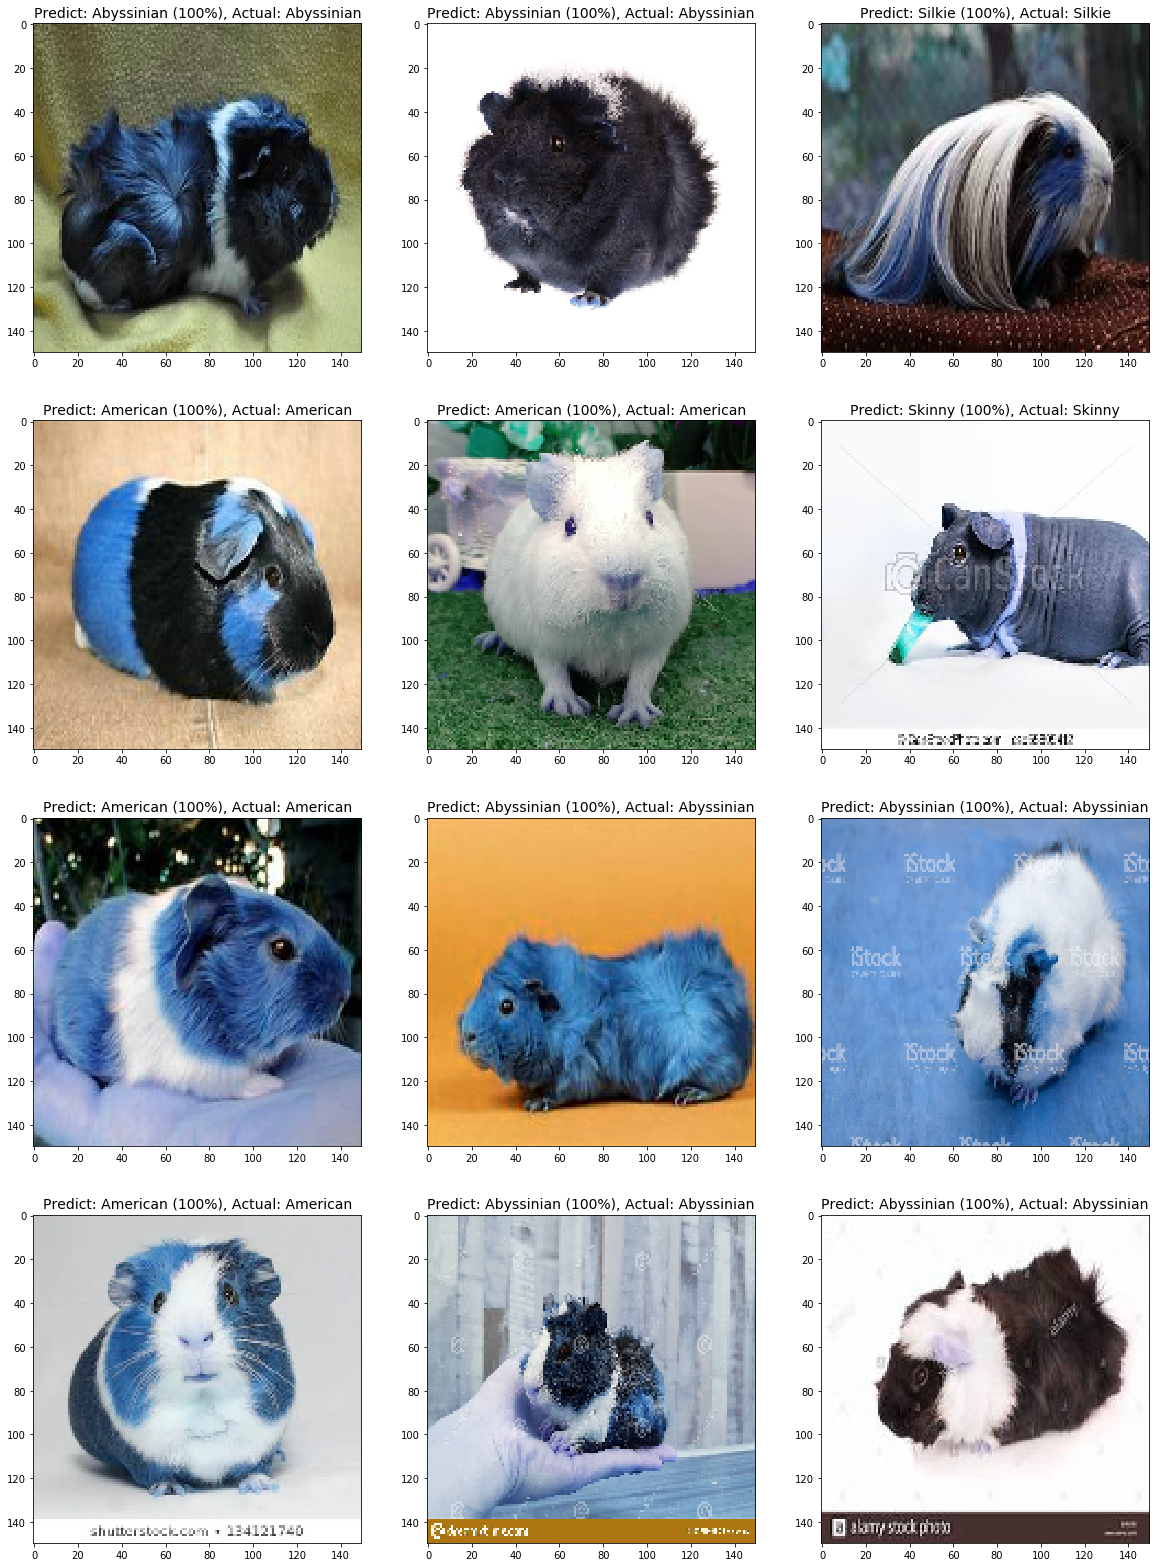

In [18]:
Image_NN_Predict_Random_Test_Images(model_inc_v3_230, X_test, y_test, target_names, input_shape, num_img=12, verbose=2)